In [1]:
import copy
import sys
import os
import glob
import time
sys.path.append('../..')

from model import processing

# asset_ls = ['DOT', 'ETH', 'SOL', 'BTC']
# usd_name = 'BUSD'
# tick = '1s'

# path = 'input/'
# extension = 'csv'
# os.chdir(path)
# os.chdir('..')
# price_data = {}
# result = []

# for prefix in asset_ls:
#     os.chdir(path)
#     asset_result = glob.glob(prefix + usd_name + '-' + tick + '-' + '*.{}'.format(extension))
#     os.chdir('..')
#     price_data[prefix] = processing.import_binance_prices(path, asset_result)[::12]


# # input_filename = 'input/DOTBUSD-1s-2022-11-22.csv'
# print(len(price_data['DOT']))
# # input_filename = 'input/test.csv'
# # output_filename = 'output/' + prefix + usd_name + "-" + tick + "-output.csv"


# # input_filename = 'DOT_crash.csv'
# # price_data = processing.import_prices(path, input_filename)


# # final_price = price_data[-1]
# # price_data.extend([final_price] * 100)
# price_list = []
# for i in range(len(price_data['DOT'])):
#     price_dict = {}
#     for asset in asset_ls:
#         price_dict[asset] = price_data[asset][i].price
#     price_list.append(price_dict)

# final_prices = price_list[-1]
# price_list.extend([copy.deepcopy(final_prices) for i in range(100)])


# we want about .000002 * TVL in volume every block

start_time = time.time()
price_list = processing.import_binance_prices(['DOT', 'ETH', 'SOL', 'BTC'], start_date='Nov 6 2022', days=4)
stop_time = time.time()
print(f'load time: {round(stop_time - start_time, 3)} seconds')  

load time: 0.963 seconds


In [2]:
from pprint import pprint
import pandas as pd
import random
import sys
from matplotlib import pyplot as plt
sys.path.append('../..')

from model import run
from model import plot_utils as pu
from model import processing
from model.amm.omnipool_amm import OmnipoolState, price, usd_price, dynamicadd_asset_fee, dynamicadd_lrna_fee
from model.amm.agents import Agent
from model.amm.trade_strategies import omnipool_arbitrage, invest_all, back_and_forth
from model.amm.global_state import GlobalState, fluctuate_prices, historical_prices

# same seed, same parameters = same simulation result
random.seed(42)

assets = {}
omnipool_assets = ['HDX', 'USD', 'AUSD', 'ETH', 'DOT']

assets = {
    'HDX': {'usd price': 0.005, 'weight': 0.10},
    'USD': {'usd price': 1, 'weight': 0.30},
    'BTC': {'usd price': price_list[0]['BTC'], 'weight': 0.10},
    'ETH': {'usd price': price_list[0]['ETH'], 'weight': 0.10},
    'DOT': {'usd price': price_list[0]['DOT'], 'weight': 0.30},
    'SOL': {'usd price': price_list[0]['SOL'], 'weight': 0.10},
}

lrna_price_usd = 22
initial_omnipool_tvl = 10000000
liquidity = {}
lrna = {}

for tkn, info in assets.items():
    liquidity[tkn] = initial_omnipool_tvl * info['weight'] / info['usd price']
    lrna[tkn] = initial_omnipool_tvl * info['weight'] / lrna_price_usd

initial_state = GlobalState(
    pools={
        'omnipool': OmnipoolState(
            tokens={
                tkn: {'liquidity': liquidity[tkn], 'LRNA': lrna[tkn]} for tkn in assets
            },
            oracles={'fee_raise': 50},  # , 'fee_lower': 7200},
            lrna_fee=dynamicadd_lrna_fee(
                minimum=0.0005,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00001,
                fee_max=0.1,
            ),
            asset_fee=dynamicadd_asset_fee(
                minimum=0.0025,
                amplification=1,
                raise_oracle_name='fee_raise',
                decay=0.00005,
                fee_max=0.4,
            ),
        )
    },
    agents = {
        'Arbitrageur': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=omnipool_arbitrage(
                pool_id='omnipool',
                arb_precision=3,
                # skip_assets=['HDX']
            )
        ),
        'Trader': Agent(
            holdings={'HDX': 1000000000, 'USD': 1000000000, 'R1': 1000000000, 'R2': 3000000000, 'DOT': 1000000000, 'LRNA': 1000000000, 'AUSD': 1000000000, 'ETH': 1000000000, 'SOL': 1000000000, 'BTC': 1000000000},
            trade_strategy=back_and_forth(
                pool_id='omnipool',
                percentage=0.00005
            )
        ),
        'LP': Agent(
            holdings={tkn: liquidity[tkn] / 10 for tkn in assets},
            trade_strategy=invest_all('omnipool')
        ),
        'LPDOT': Agent(
            holdings={'DOT': liquidity['DOT'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPUSD': Agent(
            holdings={'USD': liquidity['USD'] / 10},
            trade_strategy=invest_all('omnipool')
        ),
        'LPETH': Agent(
            holdings={'ETH': liquidity['ETH'] / 10},
            trade_strategy=invest_all('omnipool')
        )
    },
    evolve_function=historical_prices(price_list),
    # evolve_function=fluctuate_prices(volatility={tkn: 1 for tkn in assets}),
    external_market={tkn: assets[tkn]['usd price'] for tkn in assets},
    # save_data = {
    #     'prices': pu.Datastream(asset='all'),
    #     # 'pool_val': pu.Datastream(pool='omnipool', prop='pool_val'),
    #     'asset_fee': pu.Datastream(pool='omnipool', prop='asset_fee', key='all'),
    #     'lrna_fee': pu.Datastream(pool='omnipool', prop='lrna_fee', key='all'),
    #     'LP returns': pu.Datastream(agent='LP', prop='cash_out')
    # }
)
time_steps = len(price_list)-1
print(f'Running with {time_steps} time steps')
events = run.run(initial_state, time_steps=time_steps)
# events = processing.postprocessing(events, optional_params=['withdraw_val'])

Running with 28779 time steps
Starting simulation...
Execution time: 90.612 seconds.


'HDX'
'USD'
'BTC'
'ETH'
'DOT'
'SOL'


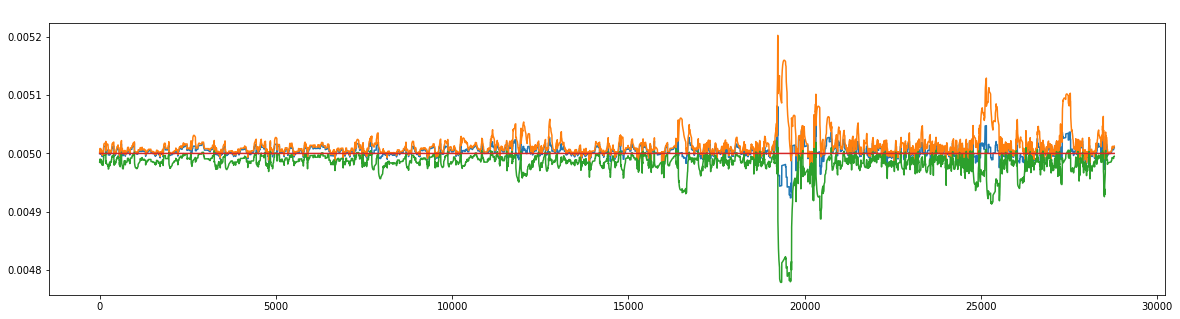

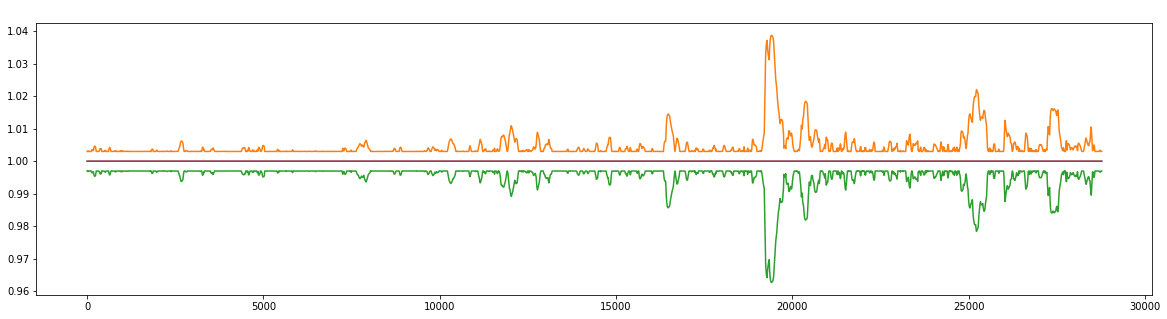

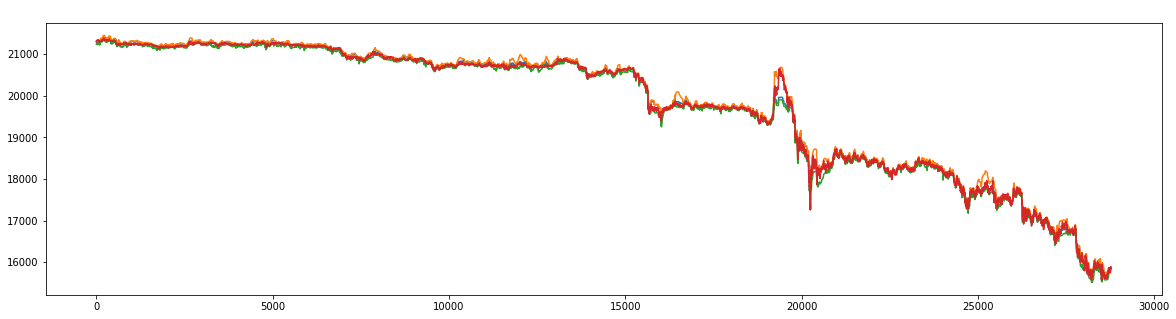

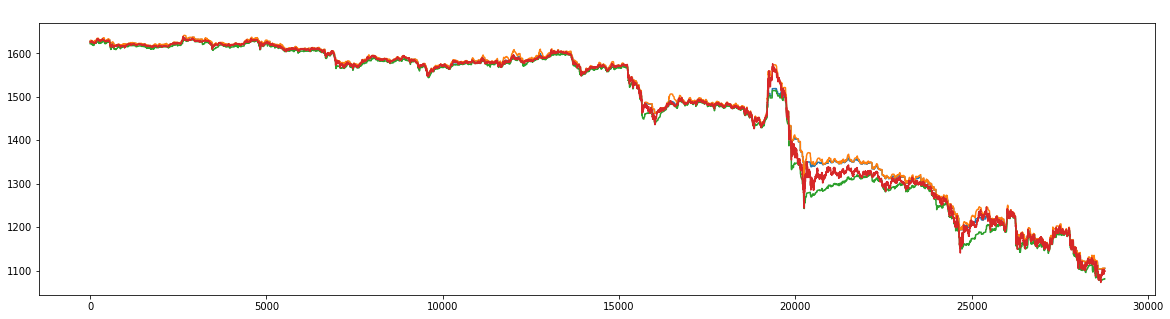

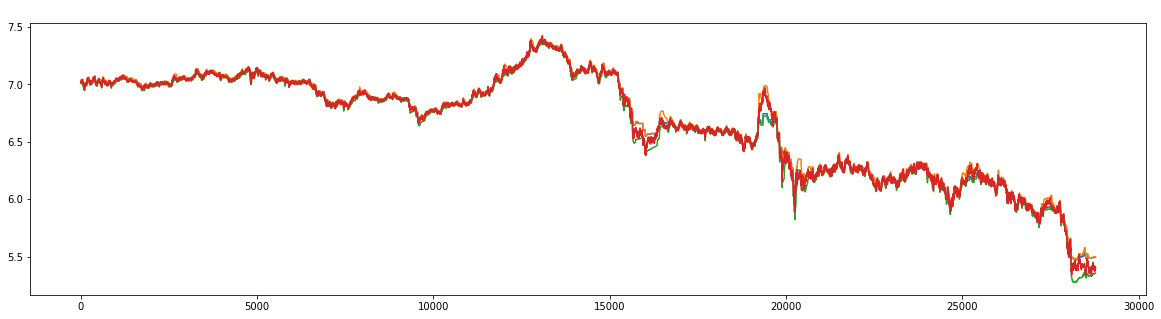

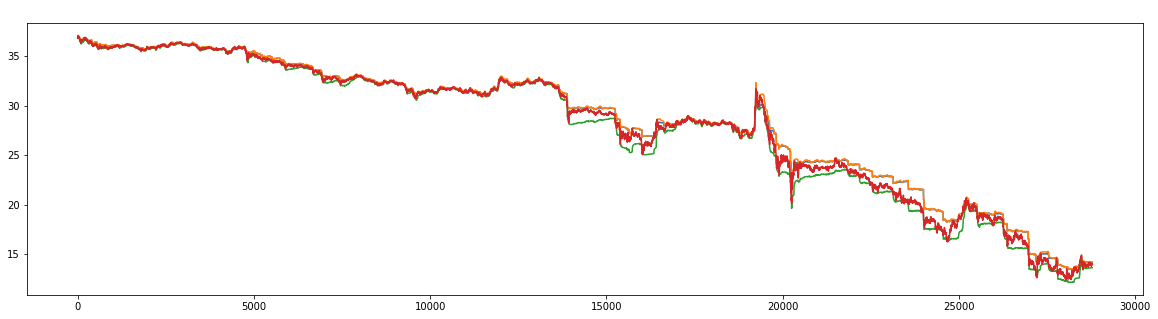

In [3]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events)
USD_lrna_fees = [None]*len(events)
for i in range(len(events)):
    op = events[i].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    prices = [None]*len(events)
    last_fees = [None]*len(events)
    last_lrna_fees = [None]*len(events)
    buy_prices = [None]*len(events)
    sell_prices = [None]*len(events)
    market_prices = [None]*len(events)
    for i in range(len(events)):
        op = events[i].pools['omnipool']
        market_prices[i] = events[i].external_market[tkn]
        prices[i] = usd_price(op, tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)


In [4]:
market = events[0].external_market
print(market)

{'HDX': 0.005, 'USD': 1, 'BTC': 21296.04, 'ETH': 1626.28, 'DOT': 7.02, 'SOL': 36.84}


:::FEES:::


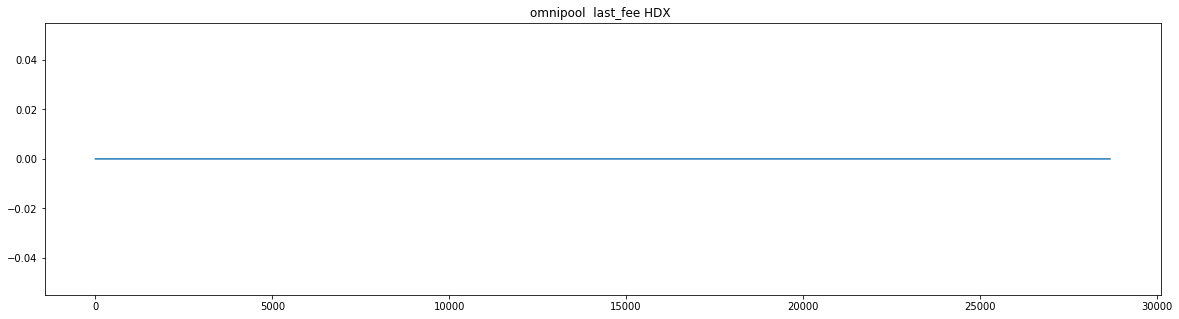

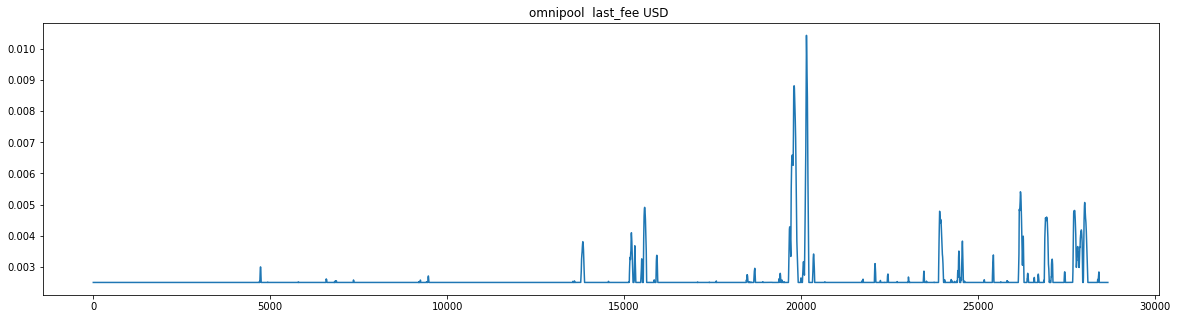

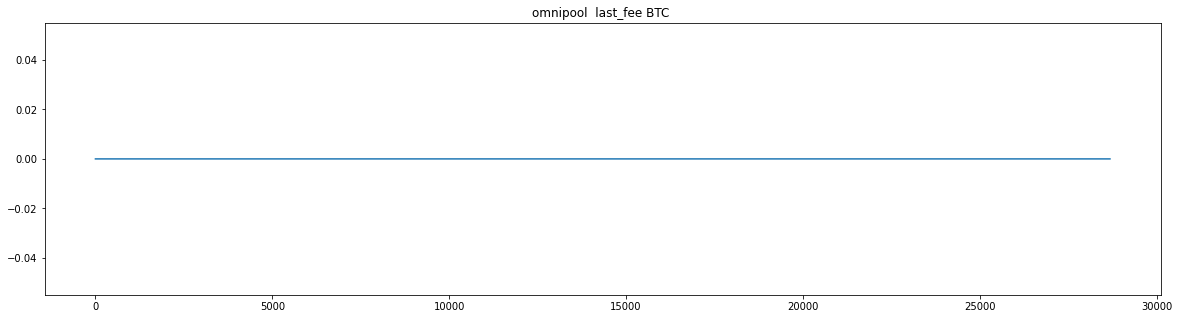

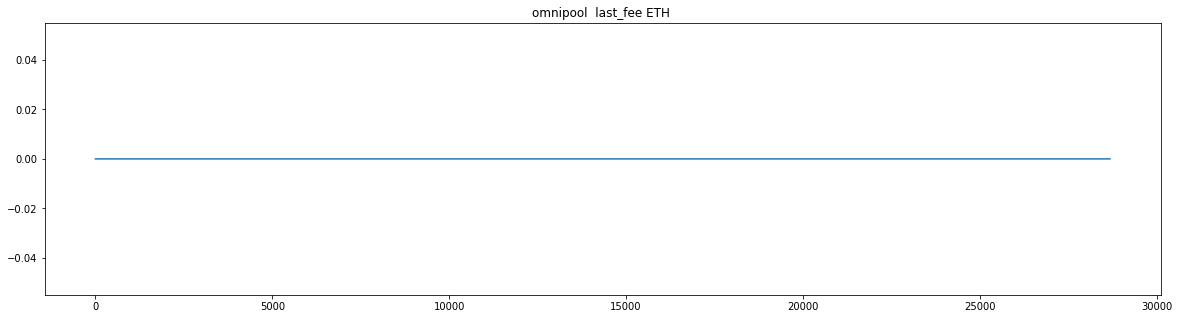

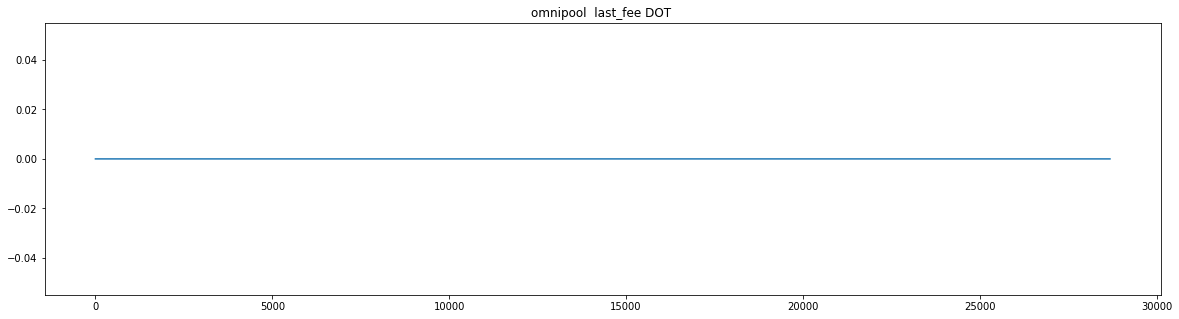

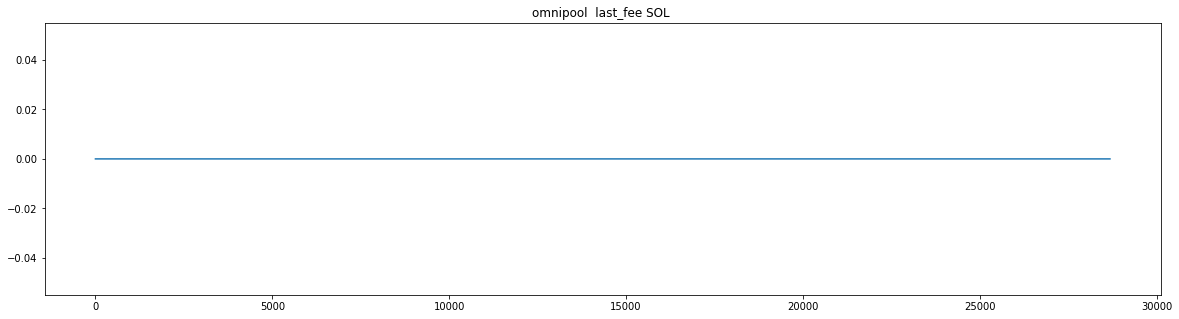

In [5]:
# print(events[0])
# dynamic_mult = [events[i].pools['omnipool'].last_mult for i in range(len(events))]
# plt.plot(range(len(dynamic_mult)), dynamic_mult)
# print(initial_state.pools['omnipool'].asset_list)
print(":::FEES:::")
# asset_fee = pu.get_datastream(events, pool='omnipool', prop='asset_fee', key='all')  # {tkn: [event['asset_fee'][tkn] for event in events[10:]] for tkn in assets}
# lrna_fee = pu.get_datastream(events, pool='omnipool', prop='lrna_fee', key='all')  # {tkn: [event['lrna_fee'][tkn] for event in events[10:]] for tkn in assets}
# print(lrna_fee['HDX'][1])
for tkn in initial_state.pools['omnipool'].asset_list:
    # print(tkn)
    # plt.figure(figsize=(20, 5))
    # ax = pu.plot(events[10:], pool='omnipool', prop='last_lrna_fee', key=tkn)
    pu.plot(events[100:], pool='omnipool', prop='last_fee', key=tkn)
    # plt.title(tkn)

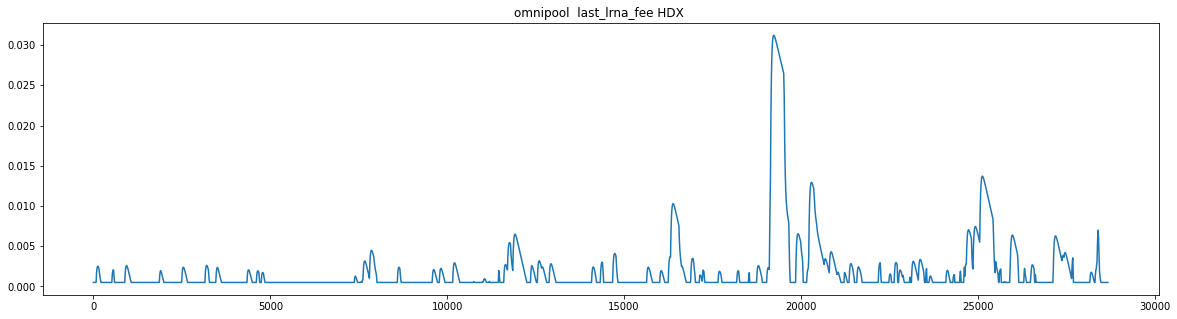

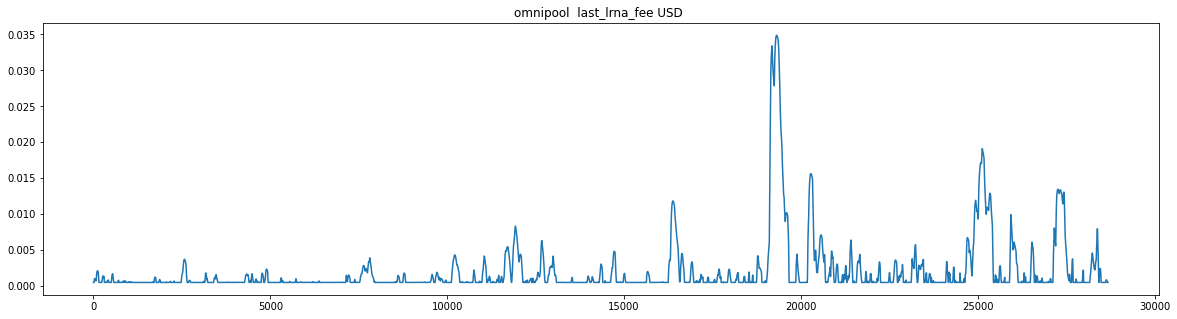

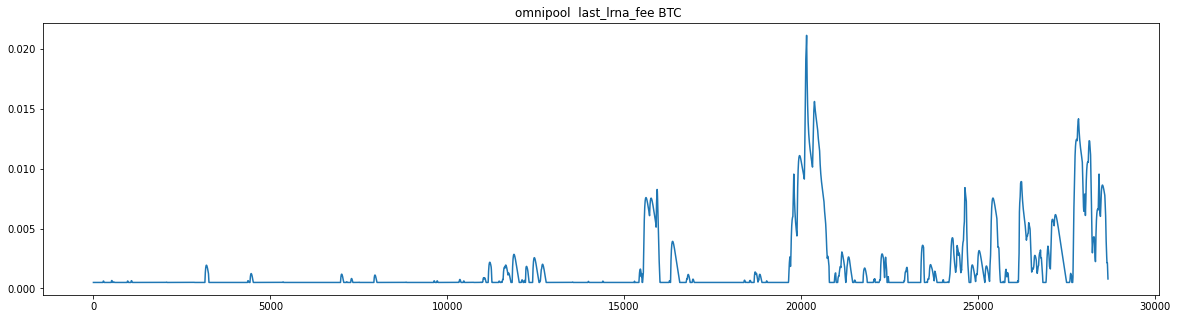

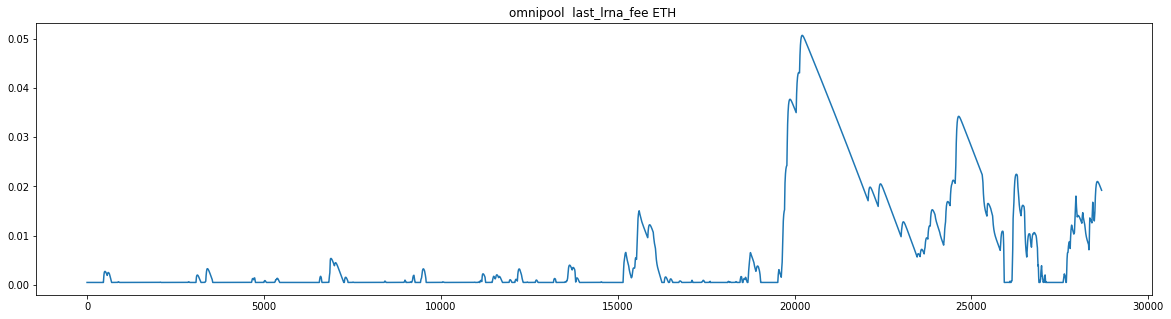

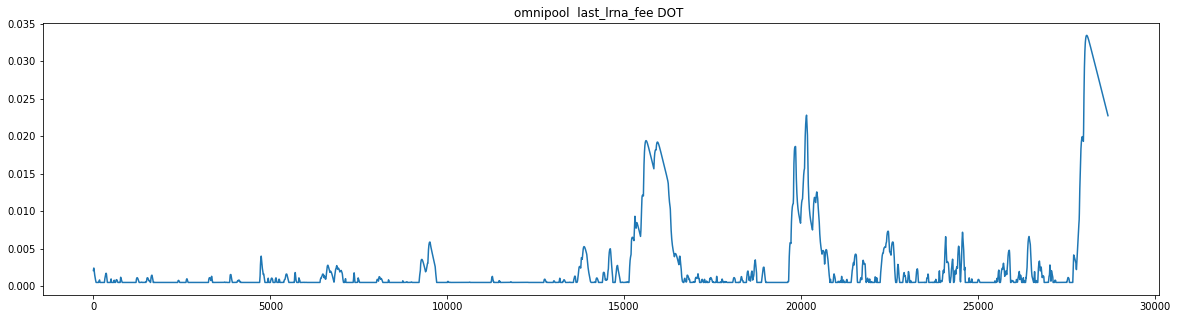

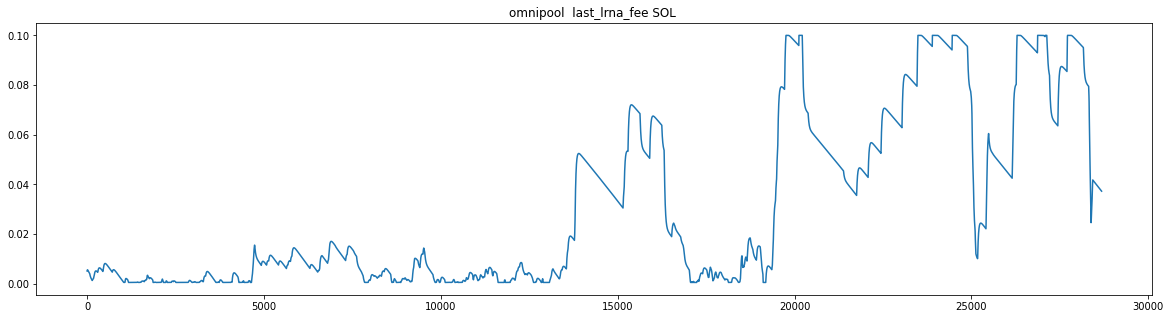

In [6]:
for tkn in initial_state.pools['omnipool'].asset_list:
    pu.plot(events[100:], pool='omnipool', prop='last_lrna_fee', key=tkn)

In [7]:
basic_state = initial_state.copy()
basic_state.pools['omnipool'].lrna_fee = 0.0005
basic_state.pools['omnipool'].asset_fee = 0.0025

events2 = run.run(basic_state, time_steps=time_steps)
# events2 = processing.postprocessing(events2, optional_params=['withdraw_val'])

# print(events2[-1])
# feeless_arbitrageur = events2[-1].agents['Arbitrageur']

Starting simulation...
Execution time: 96.384 seconds.


<AxesSubplot:title={'center':'  '}>

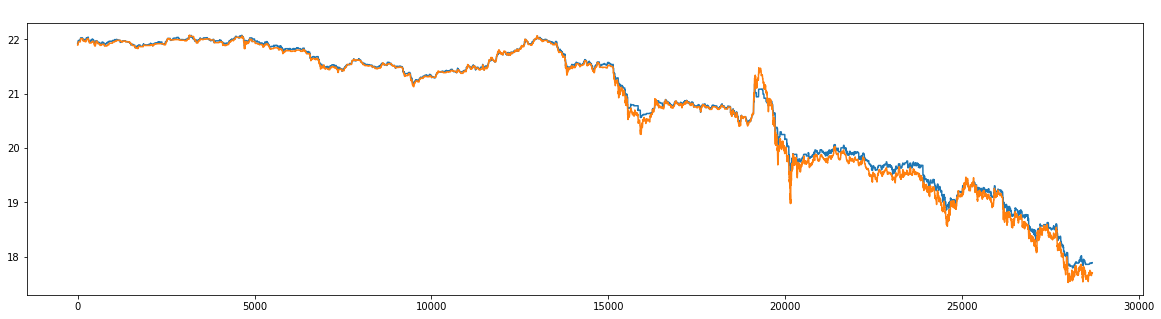

In [11]:
# for tkn in initial_state.pools['omnipool'].asset_list:
#     # print(tkn)
#     # plt.figure(figsize=(20, 5))
#     ax = pu.plot(events[100:], pool='omnipool', prop='price', key=tkn)
#     pu.plot(events2[100:], pool='omnipool', prop='price', key=tkn, subplot=ax)
#     # plt.title(tkn)

lrna_prices = [1/price(event.pools['omnipool'], 'USD') for event in events[100:]]
lrna_prices2 = [1/price(event.pools['omnipool'], 'USD') for event in events2[100:]]
ax = pu.plot(lrna_prices)
pu.plot(lrna_prices2, subplot=ax)

In [12]:
usd_index = -1
for i in range(len(initial_state.pools['omnipool'].asset_list)):
    if initial_state.pools['omnipool'].asset_list[i] == "USD":
        usd_index = i
        break

# get USD fees
USD_fees = [None]*len(events2)
USD_lrna_fees = [None]*len(events2)
for i in range(len(events2)):
    op = events2[i].pools['omnipool']
    USD_fees[i] = op.last_fee['USD']
    USD_lrna_fees[i] = op.last_lrna_fee['USD']


for tkn in initial_state.pools['omnipool'].asset_list:
    prices = [None]*len(events2)
    last_fees = [None]*len(events2)
    last_lrna_fees = [None]*len(events2)
    buy_prices = [None]*len(events2)
    sell_prices = [None]*len(events2)
    market_prices = [None]*len(events2)
    for i in range(len(events2)):
        op = events2[i].pools['omnipool']
        market_prices[i] = events2[i].external_market[tkn]
        prices[i] = op.usd_price(tkn)
        last_fees[i] = op.last_fee[tkn]
        last_lrna_fees[i] = op.last_lrna_fee[tkn]
        buy_prices[i] = prices[i] / (1 - last_fees[i]) / (1 - USD_lrna_fees[i])
        sell_prices[i] = prices[i] * (1 - USD_fees[i]) * (1 - last_lrna_fees[i])

    ax = pu.plot(prices)
    ax = pu.plot(buy_prices, subplot=ax)
    ax = pu.plot(sell_prices, subplot=ax)
    pprint(tkn)
    pu.plot(market_prices, subplot=ax)


TypeError: usd_price() missing 1 required positional argument: 'tkn'

In [ ]:
# lp_with_fees = pu.get_datastream(events, 'LP returns')
# lp_no_fees = pu.get_datastream(events2, 'LP returns')
# import cProfile, pstats
# profiler = cProfile.Profile()
# profiler.enable()

ax = pu.plot(events, agent='LP', prop='cash_out')
pu.plot(events2, agent='LP', prop='cash_out', subplot=ax)
plt.title('LP with dynamic fees (blue) vs 0.25% flat (orange)')





ax = pu.plot(events, agent='LPDOT', prop='cash_out')
pu.plot(events2, agent='LPDOT', prop='cash_out', subplot=ax)
plt.title('LPDOT with dynamic fees (blue) vs 0.25% flat (orange)')

# lp_cashout = state.cash_out(state.agents['LPDOT'])

ax = pu.plot(events, agent='LPUSD', prop='cash_out')
pu.plot(events2, agent='LPUSD', prop='cash_out', subplot=ax)
plt.title('LPUSD with dynamic fees (blue) vs 0.25% flat (orange)')

ax = pu.plot(events, agent='LPETH', prop='cash_out')
pu.plot(events2, agent='LPETH', prop='cash_out', subplot=ax)
plt.title('LPETH with dynamic fees (blue) vs 0.25% flat (orange)')

# profiler.disable()
# stats = pstats.Stats(profiler)
# stats.dump_stats('profile-data')



In [13]:
# lp_cashout = state.cash_out(state.agents['LPDOT'])


# lrna_imbalance = [event.pools['omnipool'].lrna_imbalance for event in events]
pprint(events[0].cash_out(events[0].agents['LPUSD']))
pprint(events[-1].cash_out(events[-1].agents['LPUSD']))
pprint(events2[-1].cash_out(events2[-1].agents['LPUSD']))
savings = events[-1].cash_out(events[-1].agents['LPUSD']) - events2[-1].cash_out(events2[-1].agents['LPUSD'])
pprint(savings/events[0].cash_out(events[0].agents['LPUSD']))

pprint(events[0].cash_out(events[0].agents['LPETH']))
pprint(events[-1].cash_out(events[-1].agents['LPETH']))
pprint(events2[-1].cash_out(events2[-1].agents['LPETH']))
savings = events[-1].cash_out(events[-1].agents['LPETH']) - events2[-1].cash_out(events2[-1].agents['LPETH'])
pprint(savings/events[0].cash_out(events[0].agents['LPETH']))

299999.9999999999
271011.74560325796
269756.4463974301
0.004184330686092921
99938.5477606805
67312.34508306999
67432.09237540823
-0.0011982092497981817


In [18]:
# pprint(events2[-1].cash_out(events2[-1].agents['LPDOT']))
init_omni = events[1].pools['omnipool']
final_omni = events[-1].pools['omnipool']
init_omni2 = events2[1].pools['omnipool']
final_omni2 = events2[-1].pools['omnipool']

pprint(events[-1].cash_out(events[-1].agents['LPDOT']))
pprint(events[-1].agents['LPDOT'].holdings[('omnipool', 'DOT')])
pprint(events[-1].agents['LPDOT'].share_prices[('omnipool', 'DOT')])
print(price(events[0].pools['omnipool'], 'DOT'))
print(price(events[-1].pools['omnipool'], 'DOT'))
print(price(events2[-1].pools['omnipool'], 'DOT'))
print(price(events[0].pools['omnipool'], 'USD'))
print(price(events[-1].pools['omnipool'], 'USD'))
print(price(events2[-1].pools['omnipool'], 'USD'))
print(usd_price(events[0].pools['omnipool'], 'DOT'))
print(usd_price(events[-1].pools['omnipool'], 'DOT'))
print(usd_price(events2[-1].pools['omnipool'], 'DOT'))
print(init_omni.liquidity['DOT'])
print(final_omni.liquidity['DOT'])
print(final_omni2.liquidity['DOT'])
print(init_omni.lrna['DOT'])
print(final_omni.lrna['DOT'])
print(final_omni2.lrna['DOT'])
print(init_omni.lrna_total)
print(final_omni.lrna_total)
print(final_omni2.lrna_total)
pprint(init_omni.lrna)
pprint(final_omni.lrna)
pprint(final_omni2.lrna)

pprint(events[0].agents['Arbitrageur'].holdings['LRNA'])
pprint(events[-1].agents['Arbitrageur'].holdings['LRNA'])
pprint(events2[-1].agents['Arbitrageur'].holdings['LRNA'])


# pprint(events2[0].agents['LPDOT'])
# pprint(events2[-1].agents['LPDOT'])
# pprint(events[0].agents['LPDOT'])
# pprint(events[-1].agents['LPDOT'])
# state.cash_out(state.agents['LPDOT'])


230396.56379215277
42674.25266715614
0.3195454465570479
0.3195454465570479
0.3072415473534177
0.3053493015922054
0.04545454147872611
0.05590131560246162
0.05649748485491962
7.030000439155312
5.49614162103706
5.404653010241332
512091.05014202197
522244.0793453633
524600.0389590292
163636.35920463715
160455.07903423047
160186.25551138332
531818.1787510233
531818.1787554543
531818.1756320945
{'BTC': 49999.99869326824,
 'DOT': 163636.35920463715,
 'ETH': 54545.4530682283,
 'HDX': 50000.01159063457,
 'SOL': 49999.99869326824,
 'USD': 163636.35750098675}
{'BTC': 47878.182154958646,
 'DOT': 160455.07903423047,
 'ETH': 49850.555699883516,
 'HDX': 57434.01979462894,
 'SOL': 34401.3732388052,
 'USD': 181798.96883294746}
{'BTC': 48139.527433515366,
 'DOT': 160186.25551138332,
 'ETH': 50059.2189111451,
 'HDX': 56048.31768354559,
 'SOL': 34498.11572863291,
 'USD': 182886.74036387226}
1000000000
999999999.9999985
1000000000.0000031


In [ ]:
# print(events[0], events[1000])

In [19]:
print(processing.cash_out(events[0], events[-1].agents['LP']))
print(processing.cash_out(events[-1], events[-1].agents['LP']))
print(processing.cash_out(events2[-1], events2[-1].agents['LP']))

999330.0487809957
771867.1102075528
768289.0122935958


In [20]:
print(processing.cash_out(events[0], events[-1].agents['LPDOT']))
print(processing.cash_out(events[-1], events[-1].agents['LPDOT']))
print(processing.cash_out(events2[-1], events2[-1].agents['LPDOT']))

299573.25746799406
230396.56379215277
230707.05264499196


In [21]:
print(processing.cash_out(events[0], events[-1].agents['LPUSD']))
print(processing.cash_out(events[-1], events[-1].agents['LPUSD']))
print(processing.cash_out(events2[-1], events2[-1].agents['LPUSD']))

299999.9999999999
271011.74560325796
269756.4463974301


<AxesSubplot:title={'center':'omnipool  price USD '}>

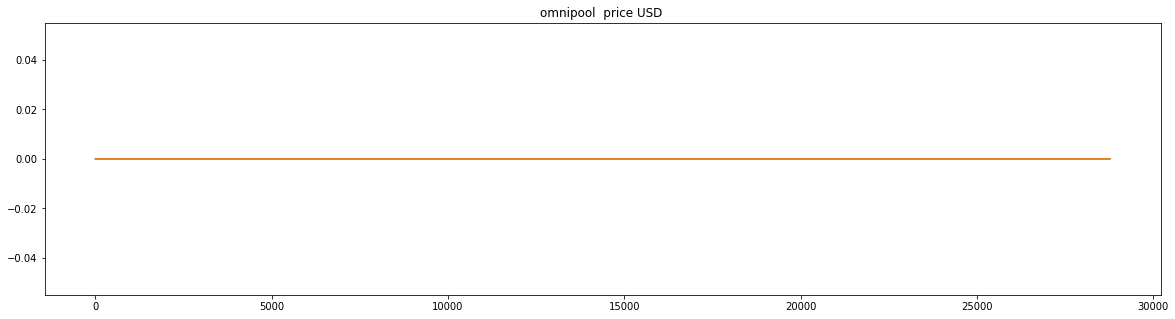

In [23]:
ax = pu.plot(events, pool='omnipool', prop='price', key='USD')
pu.plot(events2, pool='omnipool', prop='price', key='USD', subplot=ax)

In [24]:
final_pool1 = events[-1].pools['omnipool']
final_pool2 = events2[-1].pools['omnipool']
lrna_price1 = 1/events[-1].pools['omnipool'].price('USD')
print(lrna_price1)
lrna_price2 = 1/events2[-1].pools['omnipool'].price('USD')
print(lrna_price2)
total_lrna1 = sum(events[-1].pools['omnipool'].lrna[tkn] for tkn in events[-1].pools['omnipool'].asset_list)
print(total_lrna1)
total_lrna2 = sum(events2[-1].pools['omnipool'].lrna[tkn] for tkn in events2[-1].pools['omnipool'].asset_list)
print(total_lrna2)
print(lrna_price1*total_lrna1)
print(lrna_price2*total_lrna2)
print(final_pool1.lrna_imbalance) # dynamic fees cause us to burn a lot more LRNA!
print(final_pool2.lrna_imbalance)

TypeError: price() missing 1 required positional argument: 'tkn'

In [ ]:
print(initial_state)

In [ ]:
pprint(events[0].pools['omnipool'].liquidity)
pprint(events[0].agents['Trader'].holdings)
pprint(events[-1].agents['Trader'].holdings)

In [ ]:
print(events[1].pools['omnipool'].add_token)

In [ ]:
print(events[2].pools['omnipool'].add_token == events[1].pools['omnipool'].add_token)

In [ ]:
events[1].pools['omnipool'].swap